
## Summary and Methodology Notebook
> Meant as a summary notebook for the methodology used to test UI/UX of a webpage based on human attention using an ML model trained using Eye Tracking Data from the FiWI (Fixations in Webpage Images dataset)



In [1]:
!pip install poutyne #Keras like paradigm for training
!pip install albumentations #Augmentations for dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import os
import cv2
import math
import torch
import numpy as np
import albumentations as A

import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
from torch import nn
from glob import glob
from tqdm import tqdm
from natsort import natsorted
from poutyne.framework import Model
from torch.nn import functional as F
from torchvision import transforms as T
from scipy.ndimage import gaussian_filter
from torch.utils.data import Dataset, DataLoader
from typing import Tuple,TypeVar,Generic,Sequence
from torchvision.models.mobilenetv3 import mobilenet_v3_large
from poutyne.framework.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from PIL import Image,ImageDraw,ImageOps,ImageFilter

In [3]:
torch.__version__

'2.2.1+cu121'

### 0) Define some utility functions to convert discrete points to maps, perform bounding box calculations and display images
There's no real need to inspect this code, it's just some standard utility functions for quality of life improvements

In [4]:
Shape = TypeVar("Shape")
DType = TypeVar("DType")

class Array(np.ndarray, Generic[Shape, DType]):
    pass

In [5]:
def imgToDataframe(image):
  (width,height) = image.size
  df = pd.DataFrame(((x,y) for x in range(width) for y in range(height) if image.getpixel((x,y))), columns=("x","y"))
  return df

def scatterPlot(df,sigmas = [0, 13, 25, 49]):
  x = df["x"].to_numpy()
  y = df["y"].to_numpy()

  fig, axs = plt.subplots(2, 2)

  for ax, s in zip(axs.flatten(), sigmas):
      if s == 0:
          ax.plot(x, y, 'k.', markersize=5)
          ax.set_title("Scatter plot")
      else:
          img, extent = plotHeatmap(x, y, s)
          ax.imshow(img, extent=extent, origin='upper', cmap=cm.jet)
          if not s == 25:
            ax.set_title("$\sigma$ = %d" % s)
          else:
            ax.set_title("$\sigma$ = %d (Blur Sigma from the Paper)" % s)
  plt.show()

def imgToHeatmap(img,sigma=25):
  df = imgToDataframe(img)
  x = df["x"].to_numpy()
  y = df["y"].to_numpy()
  v,extnt = plotHeatmap(x,y,sigma)
  arr = ((v - v.min()) / (v.max() - v.min())) * 255
  [x0,x1,y0,y1] = [int(e) for e in extnt]
  mask = Image.fromarray(arr.astype("uint8")).resize((x1-x0,y1-y0))
  background = Image.new("L",img.size,"black")
  background.paste(mask,(int(extnt[0]),int(extnt[2]),int(extnt[1]),int(extnt[3])))
  return background

def plotHeatmap(x, y, s=25):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=1000)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [6]:
def overlay(heatmap,img,colormap=cv2.COLORMAP_JET):
    if not isinstance(heatmap, np.ndarray):
        heatmap = np.asarray(heatmap)

    item = cv2.resize(heatmap, img.size)
    item = cv2.applyColorMap(item, colormap)

    if not isinstance(img, np.ndarray):
        img = np.asarray(img)

    overlay = np.uint8(0.6 * img + 0.4 * item)
    return Image.fromarray(overlay)

def draw_rects(img,rectangles,padding=4):
    new = Image.new('RGBA', img.size, (0, 0, 0, 0))
    copy = img.copy()
    drawing = ImageDraw.Draw(new)
    for rectangle in rectangles:
        (x1, y1, x2, y2) = rectangle
        drawing.rectangle((x1-padding, y1-padding, x2+padding, y2+padding), outline=(255, 255, 255), fill=(255,255,255,255), width=padding)
    # out = Image.alpha_composite(copy.convert("RGBA"), new)
    smoothed = new.convert("L")
    return smoothed

In [7]:
def createImageGrid(images, scale=0.5, rows=1):
    w,h = images[0].size
    w = int(w*scale)
    h = int(h*scale)
    height = rows*h
    cols = math.ceil(len(images) / rows)
    width = cols*w
    canvas = Image.new('RGBA', (width,height), 'white')
    for i,img in enumerate(images):
        img = img.resize((w,h), Image.LANCZOS)
        canvas.paste(img, (w*(i % cols), h*(i // cols)))
    return canvas

In [8]:
##DTR algo from this SO answer: https://stackoverflow.com/questions/73282135/computing-bounding-boxes-from-a-mask-image-tensorflow-or-other
def mask_to_boxes(mask: Array['H,W', bool]) -> Array['N,4', int]:
    ### masks = [mask[t:b, l:r] for l, t, r, b in boxes]

    max_ix = max(s+1 for s in mask.shape)   # Use this to represent background
    # These arrays will be used to carry the "box start" indices down and to the right.
    x_ixs = np.full(mask.shape, fill_value=max_ix)
    y_ixs = np.full(mask.shape, fill_value=max_ix)

    # Propagate the earliest x-index in each segment to the bottom-right corner of the segment
    for i in range(mask.shape[0]):
        x_fill_ix = max_ix
        for j in range(mask.shape[1]):
            above_cell_ix = x_ixs[i-1, j] if i>0 else max_ix
            still_active = mask[i, j] or ((x_fill_ix != max_ix) and (above_cell_ix != max_ix))
            x_fill_ix = min(x_fill_ix, j, above_cell_ix) if still_active else max_ix
            x_ixs[i, j] = x_fill_ix

    # Propagate the earliest y-index in each segment to the bottom-right corner of the segment
    for j in range(mask.shape[1]):
        y_fill_ix = max_ix
        for i in range(mask.shape[0]):
            left_cell_ix = y_ixs[i, j-1] if j>0 else max_ix
            still_active = mask[i, j] or ((y_fill_ix != max_ix) and (left_cell_ix != max_ix))
            y_fill_ix = min(y_fill_ix, i, left_cell_ix) if still_active else max_ix
            y_ixs[i, j] = y_fill_ix

    # Find the bottom-right corners of each segment
    new_xstops = np.diff((x_ixs != max_ix).astype(np.int32), axis=1, append=False)==-1
    new_ystops = np.diff((y_ixs != max_ix).astype(np.int32), axis=0, append=False)==-1
    corner_mask = new_xstops & new_ystops
    y_stops, x_stops = np.array(np.nonzero(corner_mask))

    # Extract the boxes, getting the top-right corners from the index arrays
    x_starts = x_ixs[y_stops, x_stops]
    y_starts = y_ixs[y_stops, x_stops]
    ltrb_boxes = np.hstack([x_starts[:, None], y_starts[:, None], x_stops[:, None]+1, y_stops[:, None]+1])
    return ltrb_boxes

#### Default Deeplab v3 implementation from [Torchvision](https://pytorch.org/vision/main/models/deeplabv3.html) . We use the same strides for dilated convolutions as the default.
This should not really matter, as we will only be using the encoder portion in our final outputs. No real need to inspect the code either. We will be going into more detail later on why it doesn't matter etc.

In [9]:
class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels: int, num_classes: int, atrous_rates: Sequence[int] = (12, 24, 36)) -> None:
        super().__init__(
            ASPP(in_channels, atrous_rates),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
        )


class ASPPConv(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, dilation: int) -> None:
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        super().__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels: int, atrous_rates: Sequence[int], out_channels: int = 256) -> None:
        super().__init__()
        modules = []
        modules.append(
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU())
        )

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _res = []
        for conv in self.convs:
            _res.append(conv(x))
        res = torch.cat(_res, dim=1)
        return self.project(res)

### 1) Now download the Webpage Saliency [https://www-users.cse.umn.edu/%7Eqzhao/webpage_saliency.html](https://www-users.cse.umn.edu/%7Eqzhao/webpage_saliency.html) dataset from the University of Minnesota which provides eye tracking data points. Below are some shortcomings/features of this dataset in no particular order:


*   Screenshots are only of Above the Fold on Desktop and not Below the Fold
*   Discrete Eye Tracking data can be overlaid on Webpage Screenshot at a resolution of 1360 x 768
*   Only 149 websites tracked by 11 unique people (reduces diversity... positional biases might not be smoothed out)
*   However the CNN should be shape invariant on inference on a variety of sizes once the convolution kernels learn augmentations
*   Dataset is old and for landscape view landing pages of popular websites. Modern web design and Mobile Responsiveness not factored in.



In [10]:
!wget https://www.dropbox.com/s/30nxg2uwd1wpb80/webpage_dataset.zip?dl=0 -O webpage_dataset.zip

--2024-03-15 16:53:41--  https://www.dropbox.com/s/30nxg2uwd1wpb80/webpage_dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/30nxg2uwd1wpb80/webpage_dataset.zip [following]
--2024-03-15 16:53:41--  https://www.dropbox.com/s/raw/30nxg2uwd1wpb80/webpage_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0e10d7823a8368cf6984db9067.dl.dropboxusercontent.com/cd/0/inline/CPLCHkyltxLmZKOWca3V63wAgn2RXc265mUTXGRVNCBCkWnY0b4YQ5WXAMSlwpnXhZJN1lNS_nFT3QbWagQAFUQaUH088NibS139TLHa7Tcb8vmuB04SqcHGpswcn0V7oII/file# [following]
--2024-03-15 16:53:42--  https://uc0e10d7823a8368cf6984db9067.dl.dropboxusercontent.com/cd/0/inline/CPLCHkyltxLmZKOWca3V63wAgn2RXc265mUTXGRVNCBCkWnY0b4YQ5WXAMSlwpnXhZJN1lNS_nFT3QbWagQAFUQaUH088N

In [11]:
!rm -rf dataset

In [12]:
!unzip webpage_dataset.zip -d . | awk 'BEGIN {ORS=" "} {if(NR%10==0)print "."}'

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [13]:
!mkdir -p dataset/images
!mkdir -p dataset/masks

In [14]:
webpages = [Image.open(im) for im in natsorted(glob("dataset/stimuli/*.png"))]
tracking = [Image.open(l) for l in natsorted(glob("dataset/eyeMaps/all5/*.png"))]

In [15]:
index = 105

In [16]:
createImageGrid([webpages[index],tracking[index]],scale=0.35)

The eye tracking data is discrete points, visualizing this is almost impossible, let's see instead how to convert it to a heatmap so we can understand the data a bit better. Note, we will not be using these heatmaps directly to train, instead we get better performance from converting to a hard set of masks to train a segmentation model. This is because loss functions like certainty in ground truth data.

In [17]:
scatterPlot(imgToDataframe(tracking[index]))

We use a _Sigma of 25_ as it is the same as in the research paper associated with the dataset

In [80]:
arr = np.array(imgToHeatmap(tracking[index]).filter(ImageFilter.GaussianBlur(15)))
arr[arr > 50] = 255 #this is arbitrary
arr[arr < 255] = 0

boolean_arr = arr.astype("bool")
mask_to_boxes(boolean_arr)
new_mask = draw_rects(Image.fromarray(arr),mask_to_boxes(boolean_arr))

#overlay heatmap on webpage to get a better idea
mapped = overlay(imgToHeatmap(tracking[index]).filter(ImageFilter.GaussianBlur(5)),webpages[index])

createImageGrid([Image.fromarray(arr),mapped,Image.composite(webpages[index],Image.new("RGB",webpages[index].size,"black"),new_mask)])

We convert the eye tracking heatmaps into harder segmentation maps to encourage the model to learn a broader area (and to not _"confuse"_ it with soft boundaries)

In [20]:
for i,(page,tracked) in tqdm(enumerate(zip(webpages,tracking)),total=len(webpages)):
  arr = np.array(imgToHeatmap(tracked).filter(ImageFilter.GaussianBlur(15)))
  arr[arr > 50] = 255
  arr[arr < 255] = 0

  boolean_arr = arr.astype("bool")
  mask_to_boxes(boolean_arr)
  new_mask = draw_rects(Image.fromarray(arr),mask_to_boxes(boolean_arr))
  page.save(f"dataset/images/{str(i)}.png")
  new_mask.save(f"dataset/masks/{str(i)}.png")

100%|██████████| 149/149 [09:46<00:00,  3.93s/it]


In [21]:
!mkdir -p training/A
!mkdir -p training/B

In [22]:
!cp -R dataset/images/* training/A
!cp -R dataset/masks/* training/B

### 2) Training Datasets, Transforms and Augmentations
Note Albumentations has a bug where Geometric Mask Transforms always use NN upscaling irrespective of whether you provide Bicubic etc. Avoid this by passing in Additional Targets

However, for the current scenario a within bounds grid transform should suffice as a mild augmentation to prevent overfit on single features

In [23]:
class ImageDataset(Dataset):
  def __init__(self, Apaths,Bpaths,type="train",size=(680,384)):
    self.augment = A.Compose([
      A.GridDistortion(p=0.75),
    ], additional_targets={'image0': 'image'})

    self.transform = T.Compose([T.ToTensor(),T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    self.Apaths = Apaths
    self.Bpaths = Bpaths
    self.type = type
    self.size_h = size[1]
    self.size_w = size[0]

  def __getitem__(self, idx):

        imgA = Image.open(self.Apaths[idx]).convert("RGB").resize((self.size_w,self.size_h)) #TODO change this to folder paths if different folders
        imgB = Image.open(self.Bpaths[idx]).convert("L").resize((self.size_w,self.size_h)) #TODO change this to folder paths if different folders

        augmented = self.augment(image=np.asarray(imgA).astype("uint8"), mask=np.asarray(imgB).astype("uint8"))
        img = augmented["image"]
        mask = augmented["mask"]

        imgA = self.transform(img)
        imgB = T.ToTensor()(mask)

        return (
            imgA,
            imgB
        )

  def __len__(self):
    return min(len(self.Apaths),len(self.Bpaths))

In [24]:
Apaths = natsorted(glob(f"/content/training/A/*.png"))[0:140]
Bpaths = natsorted(glob(f"/content/training/B/*.png"))[0:140]

valApaths = natsorted(glob(f"/content/training/A/*.png"))[140:]
valBpaths = natsorted(glob(f"/content/training/B/*.png"))[140:]

In [25]:
print(len(Bpaths),len(valBpaths))

140 9


In [26]:
train_dataset = ImageDataset(Apaths=Apaths,Bpaths=Bpaths)
val_dataset = ImageDataset(Apaths=valApaths,Bpaths=valBpaths)

train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=2,shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, num_workers=2,shuffle=True)

In [27]:
data = next(iter(train_dataloader)) #check data loader working properly
img,tar = data

Let's view the training data side by side that we'll be feeding into the Deeplab segmenter

In [28]:
createImageGrid([Image.fromarray(img[0].detach().cpu().permute(1,2,0).mul(torch.tensor([0.229, 0.224, 0.225])).add(torch.tensor([0.485, 0.456, 0.406])).mul(255.).numpy().squeeze().astype("uint8")),
                 Image.fromarray(tar[0].detach().cpu().permute(1,2,0).mul(255.).numpy().squeeze().astype("uint8"),'L')
                ],scale=0.5)

In [29]:
print(tar.shape,img.shape)

torch.Size([4, 1, 384, 680]) torch.Size([4, 3, 384, 680])


### Now we create a standard Model to hard segment attention points. The Architecture really does not matter here, we will only be using the encoder section post training. Below is provided the intuition for the same.


*   The original paper uses a Multi Kernel Learning Approach, more inspectable but less accurate, and has since been surpassed by CNN, which in turn is surpassed by Vision Transformers in terms of accuracy
*   ViT provides a set of Attention heads that can be inspected using [DINO](https://github.com/facebookresearch/dino/tree/main) for soft saliency, however, it is a slower process, and is hard to implement for segmentation tasks (Note: MASK DINO might work way better, but is likely to be 10x more resource hungry than even a vanilla resnet-34)
*   In fact, even a standard CNN classifier trained on Imagenet will work to an extent, since it's ideally trained to focus on distinctive areas of an image (though not necessarily textual areas)


#### Arch we used was a Mobilenet v3 backbone in order to easily deploy to any shared runner (can use anything else, we just picked this one to tradeoff size/speed over accuracy)


*   We choose the first block of our final convolution layer. This is a little bit hit and trial, but the final conv layer is the most feature rich by definition. We found the first block (index 0) to be the best suited to us in terms of training accuracy, and while there might be a deeper theoretical explanation to this, we don't really care
*   We forward the feature outputs to the ASPP (or DSPP if you prefer) in order to perform the final segmentation and provide outputs. Once again this is standard stuff so we skew towards simplicity of implementation over fancy tricks to improve accuracy etc.




In [30]:
class DeeplabV3(nn.Module):
    def __init__(self,head:DeepLabHead):
        super(DeeplabV3, self).__init__()
        self.model = mobilenet_v3_large(True).eval() #TODO use dilations like in the Torchvision Code
        self.head = head.eval()
        self.activation = nn.Sigmoid()
        self.hooked = {}

    def forward(self,x):
        hook = self.model.features[16][0].register_forward_hook(self._forward_hook)
        input_shape = x.shape[-2:]
        y = self.model(x)
        intermediate = self.hooked['output']
        hook.remove()
        z = self.head(intermediate)
        z = self.activation(z)
        z = F.interpolate(z,size=input_shape, mode="bilinear", align_corners=False)
        return z

    def _forward_hook(self, module, inputs: Tuple[torch.Tensor], outputs):
        self.hooked['output'] = outputs

In [31]:
deeplab = DeeplabV3(DeepLabHead(960,1)).cuda() #960 feats from Mobilenet, final binary 1 channel result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 141MB/s]


In [32]:
model = Model(
    deeplab,
    'adam',
    'binary_cross_entropy',
    batch_metrics=['mse'],
    epoch_metrics=['f1'],
    device='cuda'
)

In [33]:
logs = model.fit_generator(train_dataloader, val_dataloader, epochs=20, callbacks=[
    ReduceLROnPlateau(monitor="val_loss", patience=2, verbose=True),
    EarlyStopping(monitor="val_loss", patience=4, mode='min')])

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch:  1/20 Train steps: 35 Val steps: 3 11.01s loss: 0.386378 mse: 0.119541 fscore_macro: 0.122265 val_loss: 0.311822 val_mse: 0.095209 val_fscore_macro: 0.090338
Epoch:  2/20 Train steps: 35 Val steps: 3 8.22s loss: 0.263206 mse: 0.079055 fscore_macro: 0.121008 val_loss: 0.251790 val_mse: 0.074697 val_fscore_macro: 0.101240
Epoch:  3/20 Train steps: 35 Val steps: 3 9.17s loss: 0.243858 mse: 0.073695 fscore_macro: 0.121983 val_loss: 0.322165 val_mse: 0.100582 val_fscore_macro: 0.102367
Epoch:  4/20 Train steps: 35 Val steps: 3 9.23s loss: 0.227405 mse: 0.068159 fscore_macro: 0.118875 val_loss: 0.218502 val_mse: 0.065513 val_fscore_macro: 0.089863
Epoch:  5/20 Train steps: 35 Val steps: 3 9.86s loss: 0.212488 mse: 0.063511 fscore_macro: 0.118324 val_loss: 0.232828 val_mse: 0.068190 val_fscore_macro: 0.097957
Epoch:  6/20 Train steps: 35 Val steps: 3 8.36s loss: 0.212300 mse: 0.063779 fscore_macro: 0.119297 val_loss: 0.309065 val_mse: 0.097944 val_fscore_macro: 0.101196
Epoch:  7/20 Tr

In [34]:
weights = deeplab.state_dict()

In [35]:
test_img = Image.fromarray(img[0].detach().cpu().permute(1,2,0).mul(torch.tensor([0.229, 0.224, 0.225])).add(torch.tensor([0.485, 0.456, 0.406])).mul(255.).numpy().squeeze().astype("uint8"))
pred_img = Image.fromarray(deeplab(img.cuda())[0].detach().cpu().permute(1,2,0).mul(255.).numpy().squeeze().astype("uint8"),'L')
ground_img = Image.fromarray(tar[0].detach().cpu().permute(1,2,0).mul(255.).numpy().squeeze().astype("uint8"),'L')

Comparing predictions versus ground truth, we see it looks decent as a proof of concept:

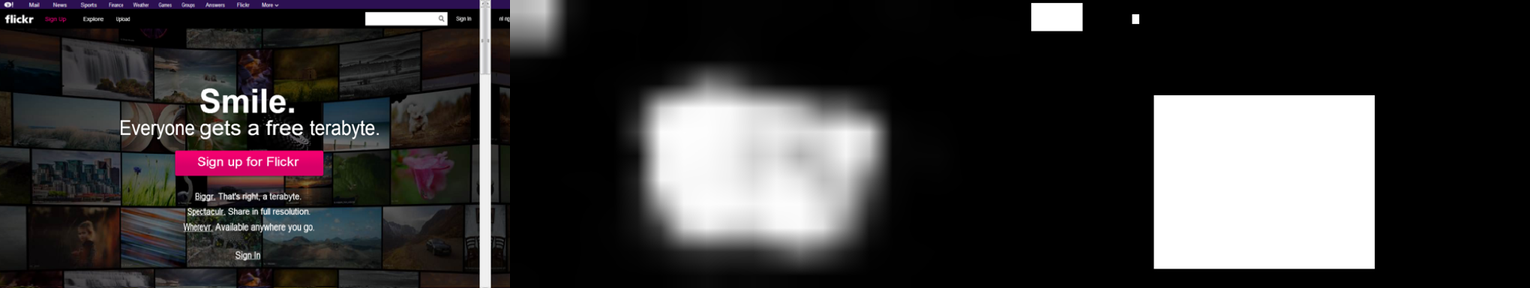

In [36]:
createImageGrid([test_img,pred_img,ground_img],scale=0.75)

### Now we simply remove Deeplab v3 head from our final weights, and convert the classifier of the backbone to produce soft segmentation maps rather than hard (Intuition provided below):

While it might be easy to think of this as a simple segmentation problem it is not really one. We are trying to model the subconscious, which is more fuzzy than simply segmenting the webpage into sections of interest. If we simply went by segmentation outputs we would find learned patterns like CTA buttons and Menu Bars or Hero Images and Text Boxes. Instead, we are trying to derive what the ML Model considers "important" while making its choices, i.e. what it uses to learn that a Hero `<img>` is more useful than a small `<p>` tag to grab human attention. This needs to be fuzzy, since under the right circumstances a misplaced `<p>` or even a `<br>` could draw the eye more than say a hero `<img>`.

Here is our solution.


*   We model the "subconscious" as the learned features by the CNN (could be Vision Transformer etc) in order to perform its current task of segmenting attentive areas based on Eye Tracking Data.
*   The most important parts of the "subconscious" then become nothing but the Eigenvectors of these Feature maps ordered by the most important being the first eigenvector
*   The percentage of importance to the "subconscious" explained by this first eigenvector is nothing but the ratio of its eigenvalue to the sum of all eigenvalues
*   Let's assume that the first eigenvector has a decent enough explainable property to effectively summarize the feature map, then the heatmap is simply the averaged data of the eigenvector multiplied by the features and scaled accordingly
*   This heatmap is a more "fuzzy" representation of human attention, is important to mitigate behavioural biases caused by a small dataset





In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.preprocess = T.Compose([T.Resize(768),T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.layer_name = "features.16.0"
        self.model = mobilenet_v3_large(True).eval()
        self.hooked = {}

    def forward(self,x):
        hook = self.model.features[16][0].register_forward_hook(self._forward_hook)
        tensor = self.preprocess(x).unsqueeze(0)
        output = self.model(tensor)
        feature = self.hooked['output']
        h,w = output.shape
        hook.remove()
        _, _, vT = torch.linalg.svd(feature)
        v1 = vT[:, :, 0, :][..., None, :]
        heatmap = feature @ v1.repeat(1, 1, v1.shape[3], 1)
        heatmap = heatmap.sum(1)
        heatmap -= heatmap.min()
        heatmap = heatmap / heatmap.max() * 255
        return heatmap

    def _forward_hook(self, module, inputs: Tuple[torch.Tensor], outputs):
        self.hooked['output'] = outputs

In [60]:
def remove_head(weights):
  weights_no_head = weights.copy()
  for key in weights:
    if "head." in key:
        del weights_no_head[key]
    # else:
    #     weights_no_head[key.replace("model.","")] = weights_no_head.pop(key)
  return weights_no_head

In [61]:
model = Net().cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
headless_weights = remove_head(weights)
model.load_state_dict(headless_weights)

<All keys matched successfully>

In [70]:
heatmap = model(T.ToTensor()(test_img).cuda()).cpu().detach().numpy().transpose(1, 2, 0).astype("uint8")

In [78]:
hard_prediction = overlay(pred_img,test_img,colormap=cv2.COLORMAP_RAINBOW)
soft_prediction = overlay(heatmap,test_img,colormap=cv2.COLORMAP_RAINBOW)

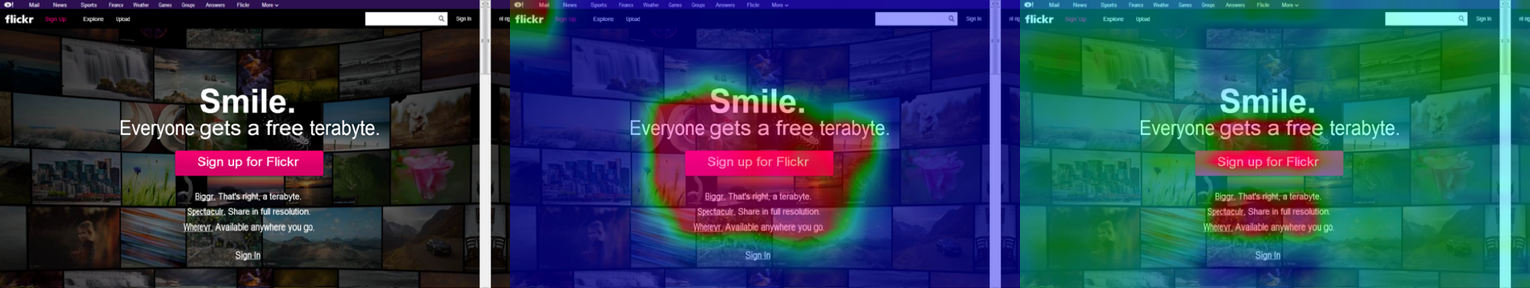

In [79]:
createImageGrid([test_img,hard_prediction,soft_prediction],scale=0.75)

In [81]:
torch.save(headless_weights,"weights_v2.pth")
torch.save(weights,"weights_segmenter.pth")